In [ ]:
#Main question. Do heritage (heritage buffer zones) affect real estate prices in European cities?
#Let's look at this question on the example of Barcelona. Let's single out the city neighborhoods (barrios) where historical buildings are located, and analyze the ratio of average real estate prices to them, in particular, the sale prices of apartments and houses.
#Next step, we could analyze the average condition factor of heritage buildings inside and the built environment by city neighborhood and predict how the average price per square meter would change if heritage renovation programs were applied.

In [ ]:
#methodology
#1. Evaluate the best way of creating a real estate prices dataset by testing API and scraping approaches, finally get a dataset with sufficient data entries,
#2. Calculate the price per sqm per each data entry in the real estate prices dataset,
#3. Match the real estate prices dataset with the Barcelona neighborhood shapefile, calculate mean, max, min and average price per sqm,
#4. Fetch heritage points and polygons from openstreetmap, create isochrones of them 100, 400 and 800 m,
#5. Fetch buildings data from the public cadastre, categorize them by heritage-like and not (already 50 years old buildings could fit the built heritage policy requirements), cluster buildings, make buffers 400m, match amount of heritage-like buildings with the Barcelona neighborhood shapefile,
#6. Make a correlation between mean, max, min and average price per sqm and heritage buffer zones, heritage-like buffer zones,
#7. Evaluate the hypothesis, check the data on conditions of heritage buildings in non-correlated zones,
#8. Develop a webpage connecting saved layers in Mapbox and setting up interactivity, visualizing maps and graphs,


In [ ]:
#We are going to use a fetched by map of building footprints from the official public cadastre web site, scraped data of real estate sales, heritage sites and points from osm map, neighborhood boundaries of Barcelona from the Geography Institute of Catalonia, 
#It is known that Idealista and Fotocasa are the top real estate web portals. In order to compare results and select the best way, we are going to achieve listings' data with scraping and API procedures.
#data sources:
#openstreet map 
#https://www.icgc.cat/en/Downloads/Vector-maps/Administrative-boundaries - Institut Cartogràfic i Geològic de Catalunya
#https://www1.sedecatastro.gob.es/ - public cadastre of Spain
#idealista.es - Spain real estate web portal #1
#fotocasa.es - Spain real estate web portal #2

#tools: 
# Idealista API + Selenium +  Pandas +  Geopandas +  Numpy +  Folium + BeautifulSoup + OSMNX + Matplotlib + Plotly + Networks + PyTorch

In [67]:
#step 1
import pandas as pd
import json
import urllib.parse
import requests as rq
import base64
import geocoder
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
import geohash2
from shapely.geometry import Point
from shapely.geometry import Polygon
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

city = "Barcelona, Barcelona, Spain"
location = geocoder.arcgis(city)
latitude = location.lat
longitude = location.lng

%matplotlib inline
ox.__version__

C:\Users\rromu\AppData\Local\Temp\ipykernel_5208\4111700985.py:20: ResourceWarning: unclosed <ssl.SSLSocket fd=4488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.163', 62292), raddr=('3.94.232.178', 443)>
  location = geocoder.arcgis(city)


'1.4.0'

In [ ]:
#retreving data via Idealista API, 50 entries max per 1 request, max 100 requests free per month, so max 100*50 = 500 entries before payment
def get_oauth_token():
    url = "https://api.idealista.com/oauth/token"    
    apikey = "30fh8h7vjg83ab39doi2npfrhv1t50i6"  # sent by idealista
    secret = "gQ8rgcWu9bW0"  # sent by idealista
    auth = base64.b64encode((apikey + ':' + secret).encode()).decode()
    headers = {'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8', 'Authorization': 'Basic ' + auth}
    params = urllib.parse.urlencode({'grant_type': 'client_credentials'})
    content = rq.post(url, headers=headers, params=params)
    bearer_token = content.json()['access_token']
    return bearer_token

def search_api(token, url):  
    headers = {'Content-Type': 'Content-Type: multipart/form-data;', 'Authorization': 'Bearer ' + token}
    content = rq.post(url, headers=headers)
    result = content.json()
    return result

country = 'es'  # values: es, it, pt
locale = 'es'  # values: es, it, pt, en, ca
language = 'es'
max_items = '50'
operation = 'sale'
property_type = 'homes' #'countryHouse'
order = 'priceDown'
center = ','.join([str(latitude), str(longitude)])
distance = '20000'
sort = 'desc'
bankOffer = 'false'

df_tot = pd.DataFrame()
limit = 10

for i in range(1, limit):
    url = ('https://api.idealista.com/3.5/' + country + '/search?operation=' + operation +  # "&locale="+locale+
           '&maxItems=' + max_items +
           '&order=' + order +
           '&center=' + center +
           '&distance=' + distance +
           '&propertyType=' + property_type +
           '&sort=' + sort +
           '&numPage=%s' +
           '&language=' + language) % i
    a = search_api(get_oauth_token(), url)
    df = pd.DataFrame.from_dict(a['elementList'])
    df_tot = pd.concat([df_tot, df])

df_tot = df_tot.reset_index()

In [ ]:
df_tot.to_csv('C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/realestate_01.csv', index=False)

In [1]:
#retreving data via Idealista2 API, defining locationId
import http.client
conn = http.client.HTTPSConnection("idealista2.p.rapidapi.com")
headers = {
    'X-RapidAPI-Key': "e547600c8emsh336ab88cbe39a23p144950jsn4502f5bff208",
    'X-RapidAPI-Host': "idealista2.p.rapidapi.com"
}

conn.request("GET", "/auto-complete?prefix=barcelona&country=es", headers=headers)
res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"locations":[{"name":"Barcelona, Barcelona","locationId":"0-EU-ES-08-13-001-019","divisible":true,"type":"location","suggestedLocationId":25309,"subTypeText":"Municipio"},{"name":"Barcelona","locationId":"0-EU-ES-08","divisible":true,"type":"location","suggestedLocationId":30070,"subTypeText":"Provincia"},{"name":"Eixample, Barcelona","locationId":"0-EU-ES-08-13-001-019-02","divisible":true,"type":"location","suggestedLocationId":33507,"subTypeText":"Distrito"},{"name":"Gràcia, Barcelona","locationId":"0-EU-ES-08-13-001-019-06","divisible":true,"type":"location","suggestedLocationId":33706,"subTypeText":"Distrito"},{"name":"El Poblenou, Barcelona","locationId":"0-EU-ES-08-13-001-019-10-008","divisible":false,"type":"location","suggestedLocationId":34248,"subTypeText":"Barrio"},{"name":"Sarrià-Sant Gervasi, Barcelona","locationId":"0-EU-ES-08-13-001-019-05","divisible":true,"type":"location","suggestedLocationId":33504,"subTypeText":"Distrito"},{"name":"Sant Andreu, Barcelona","locatio

In [5]:
#retreving data via Idealista2 API, 50 entries max per 1 request, max 500 requests free per month, so max 500*50 = 2500 entries before payment
url = "https://idealista2.p.rapidapi.com/properties/list"

headers = {
    "X-RapidAPI-Key": "e547600c8emsh336ab88cbe39a23p144950jsn4502f5bff208",
    "X-RapidAPI-Host": "idealista2.p.rapidapi.com"
}

df_tot2 = pd.DataFrame()

for page in range(30):
    querystring = {
        "locationId": "0-EU-ES-08-13-001-019",
        "locationName": "Barcelona",
        "operation": "sale",
        "numPage": str(page),
        "maxItems": "50",
        "sort": "desc",
        "locale": "en",
        "country": "es",
        "distance": "10000",
        "minPrice": "10000",
        "propertyType": "homes"
    }
    
    response = rq.get(url, headers=headers, params=querystring)
    data = response.json()
    df = pd.DataFrame.from_dict(data['elementList'])
    df_tot2 = pd.concat([df_tot2, df])

df_tot2 = df_tot2.reset_index()
df_tot2.head()

index propertyCode                                          thumbnail   
0      0    100641102  https://img3.idealista.com/blur/WEB_LISTING-M/...  \
1      1     97601445  https://img3.idealista.com/blur/WEB_LISTING-M/...   
2      2     97536243  https://img3.idealista.com/blur/WEB_LISTING-M/...   
3      3    101167817                                                NaN   
4      4     81247994  https://img3.idealista.com/blur/WEB_LISTING-M/...   

  externalReference  numPhotos       price propertyType operation    size   
0        PED-27023C         16  25000000.0       chalet      sale  1230.0  \
1             15841         60  13800000.0         flat      sale   700.0   
2         PEA21041C         11  12500000.0       chalet      sale   889.0   
3        25-5-04686          0  12000000.0         flat      sale   632.0   
4           BCN9752         43  10000000.0       chalet      sale   900.0   

   exterior  ...  topHighlight  superTopHighlight floor hasLift highlight   
0     False  ...         False              False   NaN     NaN       NaN  \
1      True  ...         False              False    en   False       NaN   
2     False  ...         False              False   NaN     NaN       NaN   
3      True  ...         False              False    bj   False       NaN   
4     False  ...         False              False   NaN     NaN       NaN   

  priceDropValue dropDate priceDropPercentage highlightComment   
0            NaN      NaN                 NaN              NaN  \
1            NaN      NaN                 NaN              NaN   
2            NaN      NaN                 NaN              NaN   
3            NaN      NaN                 NaN              NaN   
4            NaN      NaN                 NaN              NaN   

   newDevelopmentFinished  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

[5 rows x 55 columns]

In [21]:
# concatenate files from 2 APIs
csv_file = 'C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/realestate_01.csv'
df_csv = pd.read_csv(csv_file)
df_combined = pd.concat([df_tot2, df_csv], ignore_index=True)
geometry = [Point(xy) for xy in zip(df_combined['longitude'], df_combined['latitude'])]
geo_series = gpd.GeoSeries(geometry)
gdf = gpd.GeoDataFrame(df_combined, geometry=geo_series)
gdf = gdf.drop_duplicates(subset='geometry')
gdf = gdf.reset_index(drop=True)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   index                   1568 non-null   int64   
 1   propertyCode            1568 non-null   object  
 2   thumbnail               1563 non-null   object  
 3   externalReference       1440 non-null   object  
 4   numPhotos               1568 non-null   int64   
 5   price                   1568 non-null   float64 
 6   propertyType            1568 non-null   object  
 7   operation               1568 non-null   object  
 8   size                    1568 non-null   float64 
 9   exterior                1568 non-null   bool    
 10  rooms                   1568 non-null   int64   
 11  bathrooms               1568 non-null   int64   
 12  address                 1568 non-null   object  
 13  province                1568 non-null   object  
 14  municipality    

In [22]:
gdf.to_csv('C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/realestate_fromAPI.csv', index=False)

In [33]:
# Vizualize API data on map to comprehend the total scope (file name has been changed)
csv_file = 'C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/realestate_BCN.csv'
df = pd.read_csv(csv_file)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdfz = gpd.GeoDataFrame(df, geometry=geometry)

# Calculate natural breaks (jenks) for priceByArea
breaks = np.linspace(gdfz['priceByArea'].min(), gdfz['priceByArea'].max(), num=10)

# Assign colors to each point based on priceByArea using the 'magma' colormap
norm = colors.Normalize(vmin=gdfz['priceByArea'].min(), vmax=gdfz['priceByArea'].max())
cmap = cm.get_cmap('cool_r')

m = folium.Map(location=[gdfz['latitude'].mean(), gdfz['longitude'].mean()], zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(m)

# Add the points to the map with graduated colors and sizes
for index, row in gdfz.iterrows():
    price = row['priceByArea']
    color = colors.rgb2hex(cmap(norm(price)))
    size = 1.0 + (price - gdfz['priceByArea'].min()) / (gdfz['priceByArea'].max() - gdfz['priceByArea'].min()) * 5.0
    
    # Calculate the z-value based on the range of breaks
    z_value = 0
    for i in range(len(breaks) + 1):
        if price >= breaks[i] and price <= breaks[i + 1]:
            z_value = i + 1
            break
    
    folium.CircleMarker(location=[row['latitude'], row['longitude']], color=color, fill_color=color,
                        fill_opacity=0.3, radius=size, z_index=z_value).add_to(m)

# Create a legend
legend_html = '''
     <div style="position: fixed; top: 50px; left: 50px; width: 160px; height: 230px;
                background-color: white; opacity: 0.75; z-index:9999; font-size:14px; font-color: black;">
     <p><b>Jenks of Prices</b></p>
     '''
for i in range(len(breaks) - 1):
    legend_html += f'''
        <svg height="10" width="10">
          <circle cx="5" cy="5" r="5" fill="{colors.rgb2hex(cmap(norm(breaks[i])))}" opacity="0.9"></circle>
        </svg> 
        {breaks[i]:.2f} - {breaks[i + 1]:.2f}<br>
    '''
legend_html += '</div>'

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))
m

C:\Users\rromu\AppData\Local\Temp\ipykernel_5208\41431331.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool_r')


In [29]:
html_file = 'C:/WORK_IAAC/submissions/Data Science III/result.html'  # Replace with the desired path and filename
m.save(html_file)

In [ ]:
#finally we realize that not regarding that the dataset achieved by API has reach data with 56 features, data amount available for free request is limited.
#Idealista API doesnt have clear price policy for data requests - https://developers.idealista.com/access-request
#Idealista2 API provides pricing for data requests: https://rapidapi.com/apidojo/api/idealista2/pricing
#in order to meet the initial plan of analysis we are about to switch to scraped data from fotocasa.es used in a previous project.

In [38]:
shp_file = 'C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/fotocasa_2018.shp'
gdft = gpd.read_file(shp_file)
# Remove 1% of smaller outliers in 'PRECIO'
q1 = gdft['PRECIO'].quantile(0.01)
gdft = gdft[gdft['PRECIO'] >= q1]
# Convert 'PRECIO' and 'SUPERFICIE' columns to integers, ignoring NaN
gdft['PRECIO'] = pd.to_numeric(gdft['PRECIO'], errors='coerce').astype('Int64')
gdft['SUPERFICIE'] = pd.to_numeric(gdft['SUPERFICIE'], errors='coerce').astype('Int64')
# Calculate the PriceByArea column using lambda function
gdft['PriceByArea'] = gdft.apply(lambda row: row['PRECIO'] / row['SUPERFICIE'] if pd.notnull(row['PRECIO']) and pd.notnull(row['SUPERFICIE']) else np.nan, axis=1)

# Rest of the code...

# Calculate natural breaks (jenks) for priceByArea
breaks = np.linspace(gdft['PriceByArea'].min(), gdft['PriceByArea'].max(), num=10)

# Assign colors to each point based on priceByArea using the 'magma' colormap
norm = colors.Normalize(vmin=gdft['PriceByArea'].min(), vmax=gdft['PriceByArea'].max())
cmap = cm.get_cmap('cool')

m = folium.Map(location=[gdft['geometry'].centroid.y.mean(), gdft['geometry'].centroid.x.mean()], zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(m)

# Add the points to the map with graduated colors and sizes
for index, row in gdft.iterrows():
    price = row['PriceByArea']
    color = colors.rgb2hex(cmap(norm(price)))
    size = 1.0 + (price - gdft['PriceByArea'].min()) / (gdft['PriceByArea'].max() - gdft['PriceByArea'].min()) * 5.0
    
    # Calculate the z-value based on the range of breaks
    z_value = 0
    for i in range(len(breaks) - 1):
        if price >= breaks[i] and price <= breaks[i + 1]:
            z_value = i + 1
            break
    
    folium.CircleMarker(location=[row['geometry'].centroid.y, row['geometry'].centroid.x], color=color, fill_color=color,
                        fill_opacity=0.3, radius=size, z_index=z_value).add_to(m)
    
# Create a legend
legend_html = '''
     <div style="position: fixed; top: 50px; left: 50px; width: 160px; height: 230px;
                background-color: white; opacity: 0.75; z-index:9999; font-size:14px; font-color: black;">
     <p><b>Jenks of Prices</b></p>
     '''
for i in range(len(breaks) - 1):
    legend_html += f'''
        <svg height="10" width="10">
          <circle cx="5" cy="5" r="5" fill="{colors.rgb2hex(cmap(norm(breaks[i])))}" opacity="0.9"></circle>
        </svg> 
        {breaks[i]:.2f} - {breaks[i + 1]:.2f}<br>
    '''
legend_html += '</div>'

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))
m

C:\Users\rromu\AppData\Local\Temp\ipykernel_5208\304043237.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool')
C:\Users\rromu\AppData\Local\Temp\ipykernel_5208\304043237.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdft['geometry'].centroid.y.mean(), gdft['geometry'].centroid.x.mean()], zoom_start=12)


In [37]:
gdft.to_file('C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/fotocasa_2018_2.shp', driver='ESRI Shapefile')

C:\Users\rromu\AppData\Local\Temp\ipykernel_5208\3666286038.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdft.to_file('C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/fotocasa_2018_2.shp', driver='ESRI Shapefile')


C:\Users\rromu\AppData\Local\Temp\ipykernel_5208\2594542138.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool_r')


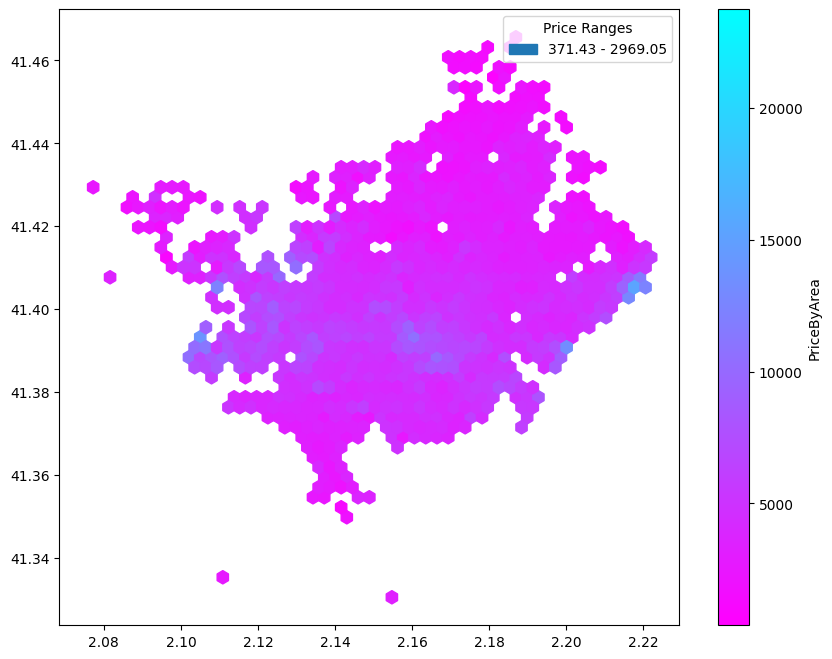

In [41]:
import matplotlib.pyplot as plt

# Read the shapefile as a GeoDataFrame
shp_file = 'C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/fotocasa_2018.shp'
gdft = gpd.read_file(shp_file)

# Remove 1% of smaller outliers in 'PRECIO'
q1 = gdft['PRECIO'].quantile(0.01)
gdft = gdft[gdft['PRECIO'] >= q1]

# Convert 'PRECIO' and 'SUPERFICIE' columns to integers, ignoring NaN
gdft['PRECIO'] = pd.to_numeric(gdft['PRECIO'], errors='coerce').astype('Int64')
gdft['SUPERFICIE'] = pd.to_numeric(gdft['SUPERFICIE'], errors='coerce').astype('Int64')

# Calculate the PriceByArea column using lambda function
gdft['PriceByArea'] = gdft.apply(lambda row: row['PRECIO'] / row['SUPERFICIE'] if pd.notnull(row['PRECIO']) and pd.notnull(row['SUPERFICIE']) else np.nan, axis=1)

# Calculate natural breaks (jenks) for PriceByArea
breaks = np.linspace(gdft['PriceByArea'].min(), gdft['PriceByArea'].max(), num=10)

# Assign colors to each point based on PriceByArea using the 'magma' colormap
norm = plt.Normalize(vmin=gdft['PriceByArea'].min(), vmax=gdft['PriceByArea'].max())
cmap = plt.cm.get_cmap('cool_r')

# Plot the honeycomb histogram
fig, ax = plt.subplots(figsize=(10, 8))
hexbin = ax.hexbin(gdft.geometry.x, gdft.geometry.y, C=gdft['PriceByArea'], gridsize=50, cmap=cmap, norm=norm)
cbar = fig.colorbar(hexbin, ax=ax)
cbar.set_label('PriceByArea')

# Create a legend
legend_labels = []
for i in range(len(breaks) - 1):
    legend_labels.append(f'{breaks[i]:.2f} - {breaks[i + 1]:.2f}')
legend = ax.legend(legend_labels, loc='upper right', title='Price Ranges')

plt.show()